In [2]:
import os
import sys
import logging
import argparse

pth = '/'.join(sys.path[0].split('/')[:-1])
sys.path.insert(0, pth)

from PIL import Image
import numpy as np
np.random.seed(1)

home_dir = os.path.abspath(os.getcwd()+"/../")
sys.path.append(home_dir)
print(home_dir)

import torch
from torchvision import transforms

from detectron2.data import MetadataCatalog
from detectron2.structures import BitMasks
from xdecoder.BaseModel import BaseModel
from xdecoder import build_model
from detectron2.utils.colormap import random_color
from utils.visualizer import Visualizer
from utils.distributed import init_distributed

import warnings
warnings.filterwarnings(action='ignore')
logger = logging.getLogger(__name__)

from utils.arguments import load_opt_from_config_files, load_config_dict_to_opt

/home/djjin/Mygit/X-Decoder


/home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Invalid MIT-MAGIC-COOKIE-1 keyWARNING: Cannot find VLPreDataset. Make sure datasets are accessible if you want to use them for training or evaluation.


In [3]:
parser = argparse.ArgumentParser(description='Pretrain or fine-tune models for NLP tasks.')
parser.add_argument('--command', default="evaluate", help='Command: train/evaluate/train-and-evaluate')
parser.add_argument('--conf_files', nargs='+', help='Path(s) to the config file(s).')
parser.add_argument('--user_dir', help='Path to the user defined module for tasks (models, criteria), optimizers, and lr schedulers.')
parser.add_argument('--config_overrides', nargs='*', help='Override parameters on config with a json style string, e.g. {"<PARAM_NAME_1>": <PARAM_VALUE_1>, "<PARAM_GROUP_2>.<PARAM_SUBGROUP_2>.<PARAM_2>": <PARAM_VALUE_2>}. A key with "." updates the object in the corresponding nested dict. Remember to escape " in command line.')
parser.add_argument('--overrides', help='arguments that used to override the config file in cmdline', nargs=argparse.REMAINDER)

cmdline_args = parser.parse_args('')

In [4]:
cmdline_args.conf_files = [os.path.join(home_dir, "configs/xdecoder/segvlp_focalt_lang.yaml")]
cmdline_args.overrides = ['WEIGHT', 'true', 'RESUME_FROM', '../checkpoints/xdecoder_focalt_last_novg.pt']
cmdline_args.overrides

['WEIGHT',
 'true',
 'RESUME_FROM',
 '../checkpoints/xdecoder_focalt_last_novg.pt']

In [5]:
opt = load_opt_from_config_files(cmdline_args.conf_files)

keys = [cmdline_args.overrides[idx*2] for idx in range(len(cmdline_args.overrides)//2)]
vals = [cmdline_args.overrides[idx*2+1] for idx in range(len(cmdline_args.overrides)//2)]
vals = [val.replace('false', '').replace('False','') if len(val.replace(' ', '')) == 5 else val for val in vals]
types = []
for key in keys:
    key = key.split('.')
    ele = opt.copy()
    while len(key) > 0:
        ele = ele[key.pop(0)]
    types.append(type(ele))

config_dict = {x:z(y) for x,y,z in zip(keys, vals, types)}
config_dict

load_config_dict_to_opt(opt, config_dict)
for key, val in cmdline_args.__dict__.items():
    if val is not None:
        opt[key] = val

In [6]:
opt = init_distributed(opt)

In [7]:
pretrained_pth = os.path.join(opt["RESUME_FROM"])
if "novg" not in pretrained_pth:
    assert (
        False
    ), "Using the ckpt without visual genome training data will be much better."
output_root = "./output"
image_pth = "../images/animals.png"

model = (
    BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
)
model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(
    ["background"], is_eval=False
)

In [8]:
t = []
t.append(transforms.Resize(224, interpolation=Image.BICUBIC))
transform = transforms.Compose(t)
transform

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
)

2023-08-25 23:51:16.274455: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 23:51:17.045008: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/djjin/anaconda3/envs/conda_visual_HPE/lib/python3.9/site-packages/cv2/../../lib64:/home/djjin/Github/doosan_ws/devel/lib:/opt/ros/noetic/lib:/opt/ros/noetic/lib/x86_64-linux-gnu:/usr/local/cuda-11.7/lib64:/home/djjin/.mujoco/mujoco210/bin:/usr/lib/nvidia
2023-08-25 23:51:17.045076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

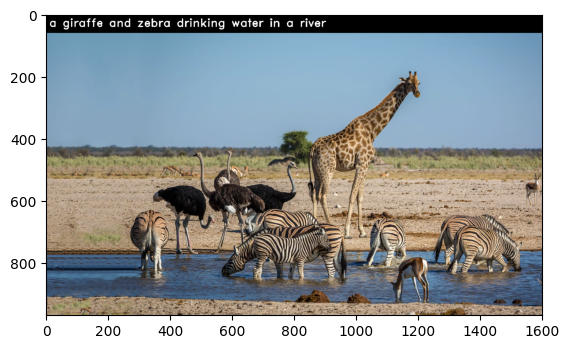

: 

In [9]:
# from matplotlib import pyplot as plt
import cv2
from matplotlib import pyplot as plt
with torch.no_grad():
    image_ori = Image.open(image_pth).convert("RGB")
    width = image_ori.size[0]
    height = image_ori.size[1]
    image = transform(image_ori)
    image = np.asarray(image)
    image_ori = np.asarray(image_ori)
    images = torch.from_numpy(image.copy()).permute(2, 0, 1).cuda()

    batch_inputs = [
        {"image": images, "height": height, "width": width, "image_id": 0}
    ]
    outputs = model.model.evaluate_captioning(batch_inputs)
    text = outputs[-1]["captioning_text"]

    image_ori = image_ori[:, :, ::-1].copy()
    cv2.rectangle(image_ori, (0, 0), (width, 60), (0, 0, 0), -1)
    font = cv2.FONT_HERSHEY_DUPLEX
    fontScale = 1.2
    thickness = 2
    lineType = 2
    bottomLeftCornerOfText = (10, 40)
    fontColor = [255, 255, 255]
    cv2.putText(
        image_ori,
        text,
        bottomLeftCornerOfText,
        font,
        fontScale,
        fontColor,
        thickness,
        lineType,
    )
    
    # if not os.path.exists(output_root):
    #     os.makedirs(output_root)
    # cv2.imwrite(os.path.join(output_root, "captioning.png"), image_ori)
    image_ori = cv2.cvtColor(image_ori, cv2.COLOR_BGR2RGB)
    plt.imshow(image_ori)
    plt.show()